In [9]:
!pip install ipywidgets

In [13]:
from google.colab import output
output.enable_custom_widget_manager()
import numpy as np
import cv2
import matplotlib.pyplot as plt
from IPython.display import display
import ipywidgets as widgets

In [14]:
class InteractiveGeometricFilter:
    def __init__(self):
        # Create test image
        self.image_size = (256, 256)
        self.image = np.zeros(self.image_size, dtype=np.uint8)
        cv2.putText(self.image, 'Digital', (30, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, 255, 2)
        cv2.putText(self.image, 'Image', (30, 150), cv2.FONT_HERSHEY_SIMPLEX, 2, 255, 2)

        # Create PSF and degraded image
        self.psf = self.create_motion_psf()
        self.noise_std = 5
        self.degraded = self.apply_degradation()

        # Create widgets
        self.setup_widgets()

        # Create initial plot
        self.update_plot(None)

    def create_motion_psf(self, angle=45, motion_dist=10):
        psf = np.zeros(self.image_size)
        center = (self.image_size[0]//2, self.image_size[1]//2)

        angle_rad = np.deg2rad(angle)
        dx = motion_dist * np.cos(angle_rad)
        dy = motion_dist * np.sin(angle_rad)

        cv2.line(psf,
                 (int(center[1] - dx/2), int(center[0] - dy/2)),
                 (int(center[1] + dx/2), int(center[0] + dy/2)),
                 1, 1, cv2.LINE_AA)

        return psf / psf.sum()

    def apply_degradation(self):
        F = np.fft.fft2(self.image.astype(float))
        H = np.fft.fft2(self.psf, s=self.image.shape)
        blurred = np.real(np.fft.ifft2(F * H))
        noisy = blurred + np.random.normal(0, self.noise_std, self.image.shape)
        return np.clip(noisy, 0, 255).astype(np.uint8)

    def setup_widgets(self):
        self.alpha_slider = widgets.FloatSlider(
            value=0.5,
            min=0,
            max=1.0,
            step=0.01,
            description='α:',
            continuous_update=False
        )

        self.beta_slider = widgets.FloatSlider(
            value=1.0,
            min=0.1,
            max=5.0,
            step=0.1,
            description='β:',
            continuous_update=False
        )

        # Register update function
        self.alpha_slider.observe(self.update_plot, names='value')
        self.beta_slider.observe(self.update_plot, names='value')

        # Display widgets
        display(widgets.VBox([self.alpha_slider, self.beta_slider]))

    def calculate_filter_response(self, alpha, beta):
        # Create frequency axis
        freq = np.linspace(0, 1, 1000)

        # Create simplified filter response
        H = np.exp(-freq**2)  # Simplified degradation model
        Sn_Sf = 0.01  # Simplified noise-to-signal ratio

        # Calculate geometric mean filter response
        term1 = np.power(1/H, alpha)
        term2 = np.power(1/(H**2 + beta * Sn_Sf), (1-alpha))
        response = np.abs(term1 * term2)

        return freq, response

    def apply_geometric_filter(self, alpha, beta):
        G = np.fft.fft2(self.degraded.astype(float))
        H = np.fft.fft2(self.psf, s=self.image.shape)

        # Estimate spectra
        Sn = self.noise_std**2
        H_mag_squared = np.abs(H)**2
        window = np.hanning(self.image.shape[0])[:, None] * np.hanning(self.image.shape[1])[None, :]
        smoothed_periodogram = np.abs(G)**2 * window
        Sf = smoothed_periodogram / (H_mag_squared + 1e-10)
        Sf = np.maximum(Sf, 1e-10)

        # Apply filter
        H_conj = np.conjugate(H)
        eps = 1e-10

        term1 = np.power(H_conj / (H_mag_squared + eps), alpha)
        wiener_denominator = H_mag_squared + beta * (Sn/Sf)
        term2 = np.power(H_conj / (wiener_denominator + eps), 1-alpha)

        F = term1 * term2 * G
        restored = np.real(np.fft.ifft2(F))

        return np.clip(restored, 0, 255).astype(np.uint8)

    def update_plot(self, change):
        alpha = self.alpha_slider.value
        beta = self.beta_slider.value

        # Create figure
        plt.figure(figsize=(15, 8))

        # Plot images
        plt.subplot(231)
        plt.imshow(self.image, cmap='gray')
        plt.title('Original')
        plt.axis('off')

        plt.subplot(232)
        plt.imshow(self.degraded, cmap='gray')
        plt.title('Degraded')
        plt.axis('off')

        # Apply and plot restored image
        restored = self.apply_geometric_filter(alpha, beta)
        plt.subplot(233)
        plt.imshow(restored, cmap='gray')
        plt.title(f'Restored (α={alpha:.2f}, β={beta:.2f})')
        plt.axis('off')

        # Plot frequency response
        plt.subplot(212)
        freq, response = self.calculate_filter_response(alpha, beta)
        plt.plot(freq, response)
        plt.title('Filter Frequency Response')
        plt.xlabel('Frequency')
        plt.ylabel('Magnitude')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

def main():
    # Clear previous output
    output.clear()

    # Create and display interactive filter
    interactive_filter = InteractiveGeometricFilter()


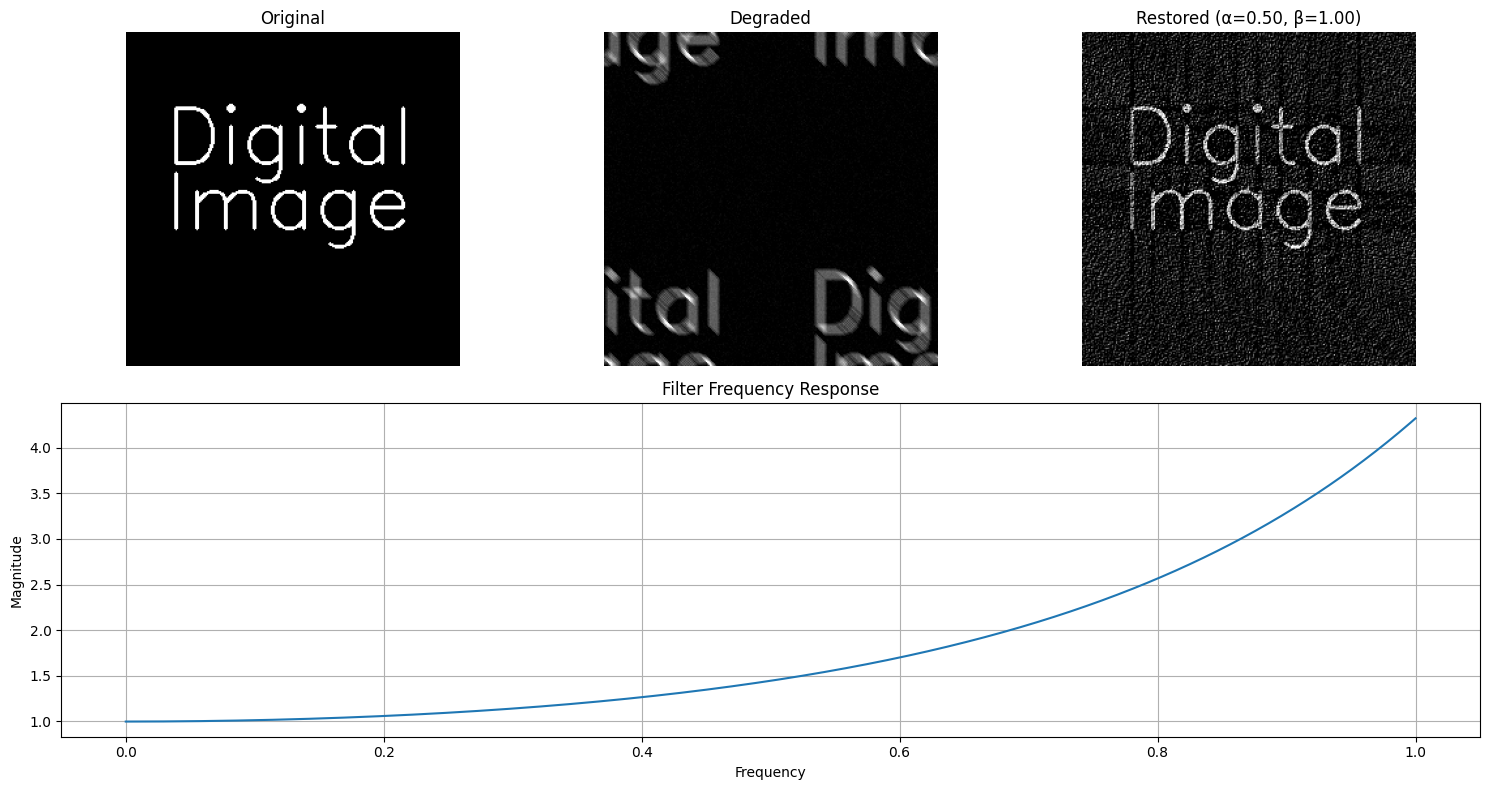

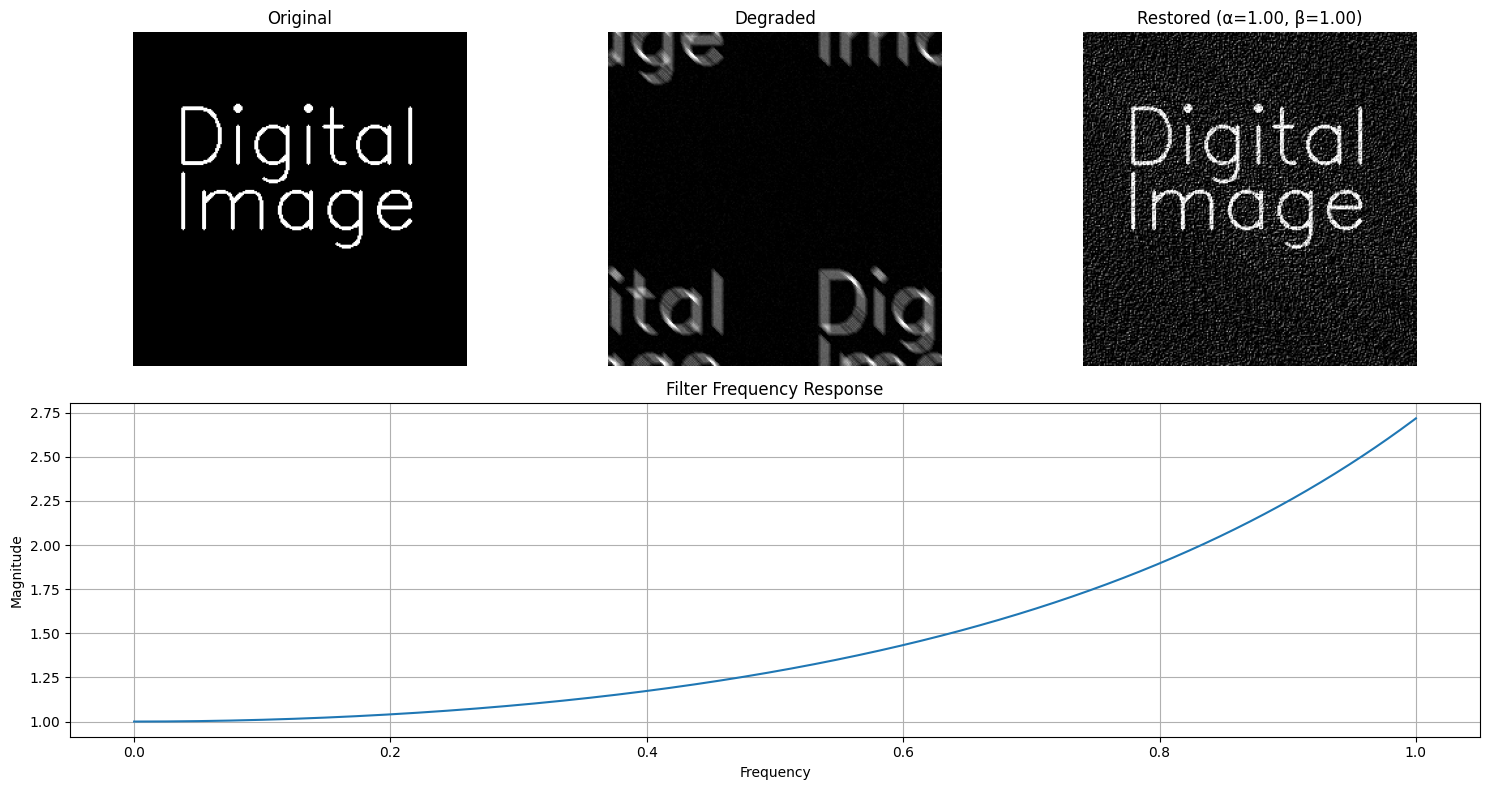

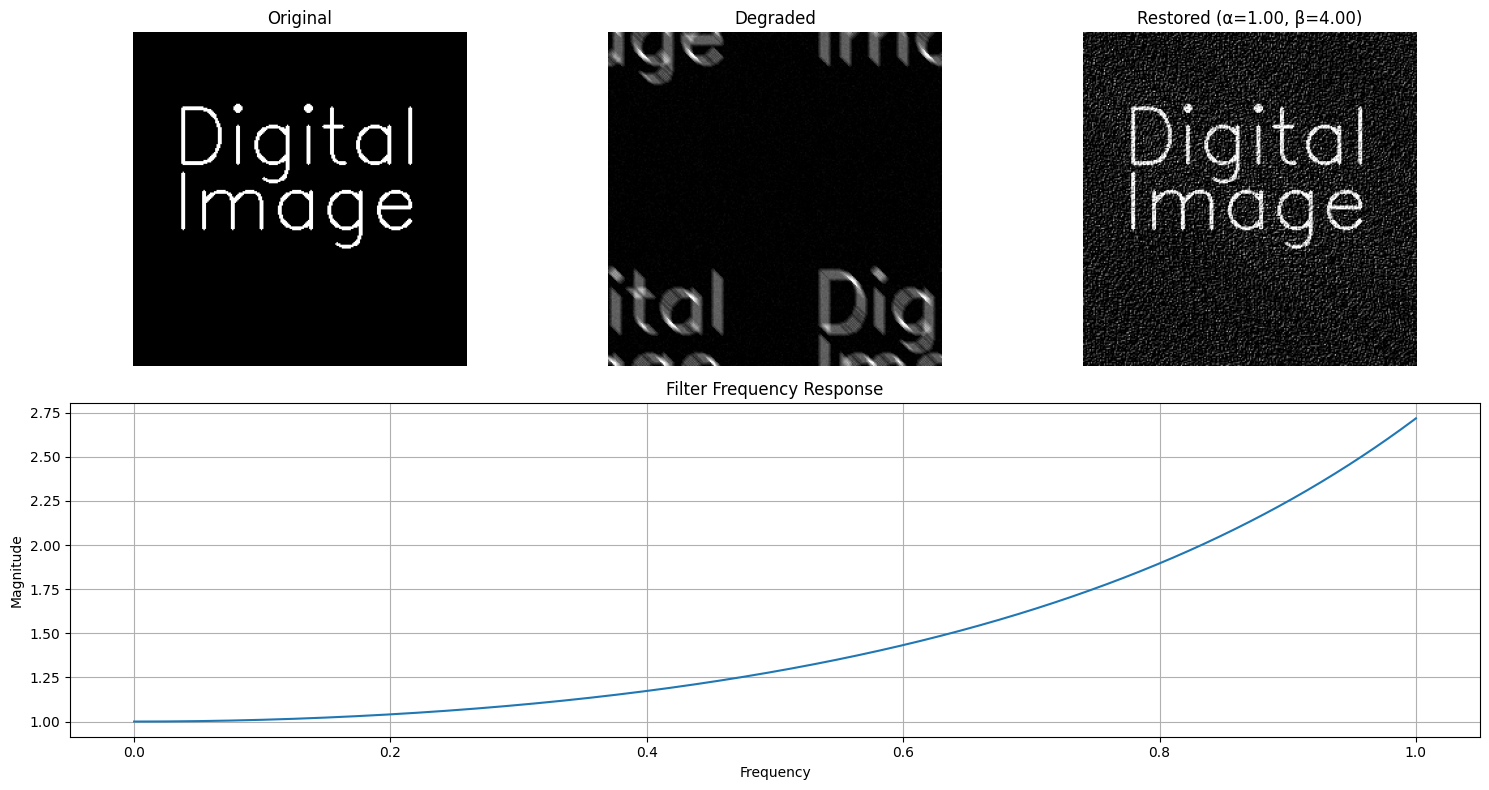

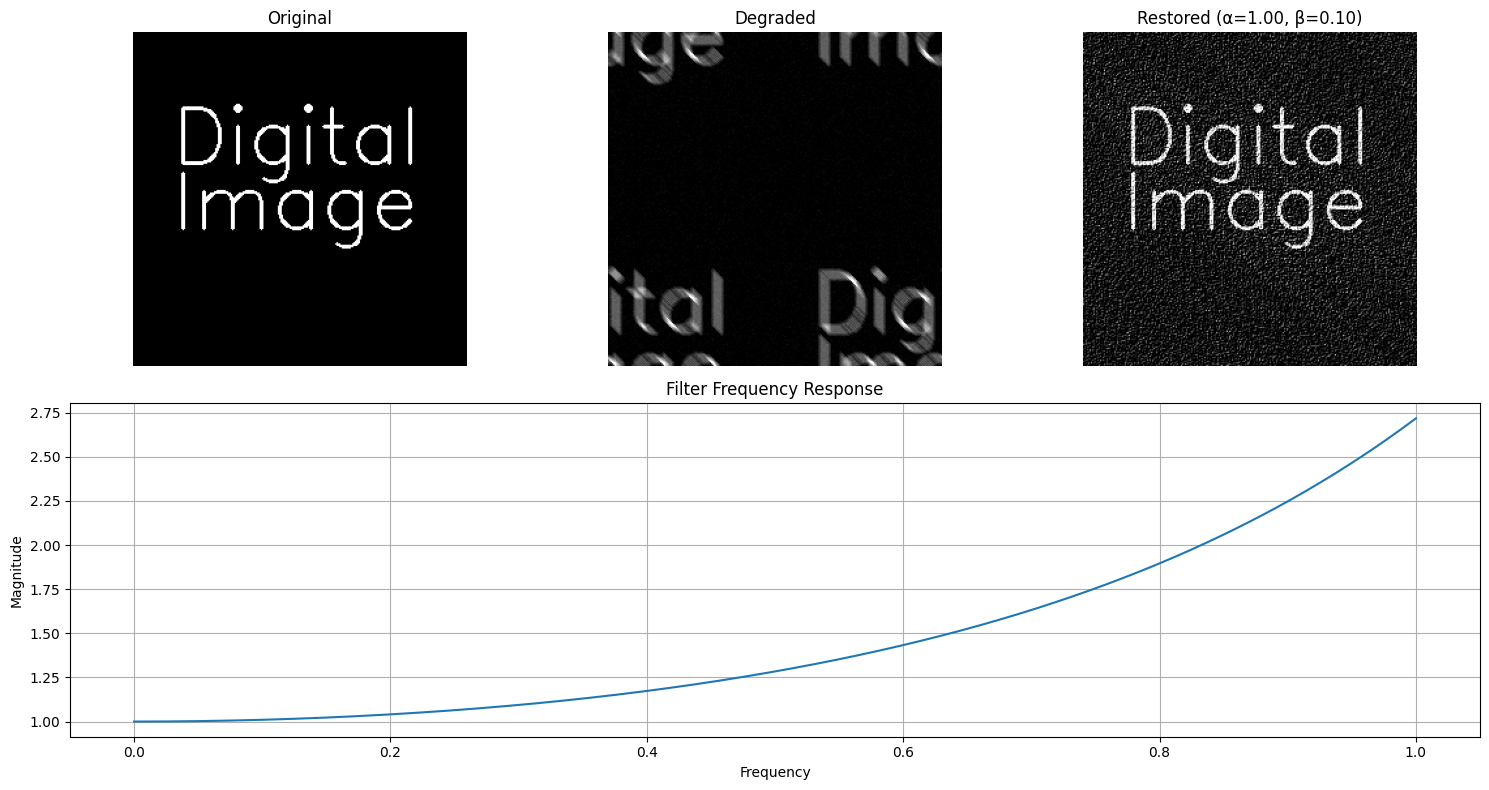

In [15]:
main()